In [1]:
import math
import glob
import numpy as np
import scipy.ndimage
import imageio.v2 as imageio
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image, ImageOps, ImageChops

## 1. Load Image

also convert it to a grayscale floating point array in [0, 1]. (Grayscale because it makes finding lines much simpler)

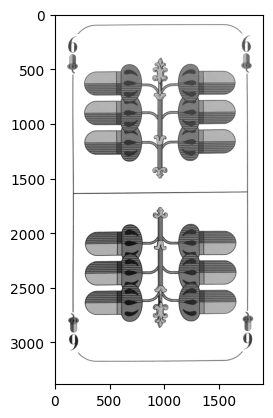

In [2]:
image_path = 'faces/e-6.jpg'
original_image = imageio.imread(image_path)
grayscale = lambda img: np.mean(img, axis=2)
image = grayscale(original_image)
image = np.asarray(image, dtype=np.float32) / 255
plt.imshow(image, cmap='gray', vmin=0, vmax=1)
plt.show()

## 2. Calculate edges

We're calculating edges with sobel to find horizontal and vertical lines.

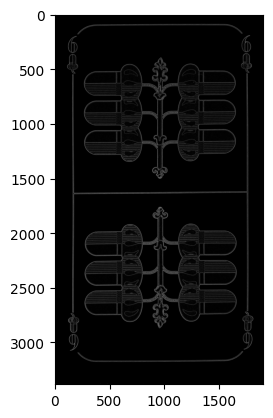

In [3]:
filter_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])
filter_y = filter_x.T

edges_x = scipy.ndimage.convolve(image, filter_x)
edges_y = scipy.ndimage.convolve(image, filter_y)

edge_image = np.sqrt(edges_x ** 2 + edges_y ** 2)

plt.figure()
plt.imshow(edge_image, cmap='gray')
plt.show()

## 3. Really simplified thing similar to the Hough-Transformation

Every pixel is voting for a line position, if the pixel looks like it could be in that line (it's part of an edge, it's oriented in the right direction).

In [4]:
THRESHOLD = 0.1
MIN_RATIO = 2

def accumulate(edge_image, edges_x, edges_y):
    # vertical (horizontal) line: see where horizontal (vertical) change is above a threshold and where horizontal (vertical) change is much larger than the vertical (horizontal) change
    worthy_vertical = (edges_x > THRESHOLD) & (edges_y / np.maximum(edges_x, THRESHOLD) < 1 / MIN_RATIO)
    worthy_horizontal = (edges_y > THRESHOLD) & (edges_x / np.maximum(edges_y, THRESHOLD) < 1 / MIN_RATIO)
    # then accumulate the horizontal (vertical) change along the vertical (horizontal) axis where points could be a vertical (horizontal) line
    accu_vertical = np.sum(edge_image, where=worthy_vertical, axis=0)
    accu_horizontal = np.sum(edge_image, where=worthy_horizontal, axis=1)
    return accu_vertical, accu_horizontal

# detect 2 vertical and 2 horizontal lines
vertical_accumulator, horizontal_accumulator = accumulate(edge_image, edges_x, edges_y)

## 4. Line Detection

The simplest thing way to find the most prominent lines is just taking the top accumulated line positions.

In [5]:
def detect_lines_simple(acc, n):
    return np.argsort(acc)[-n:]

vertical_lines = detect_lines_simple(vertical_accumulator, 10)
horizontal_lines = detect_lines_simple(horizontal_accumulator, 15)

### Problem

This gives us way too many lines, where there's only actually 1 line.

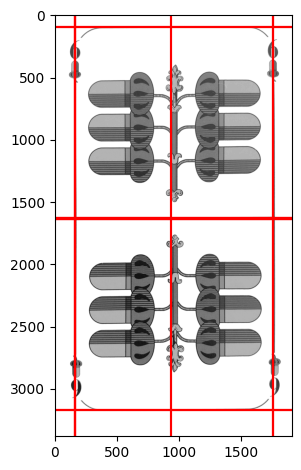

In [6]:
def plot_vertical(x, image_shape):
    plt.plot([x, x], [0, image_shape[0] - 1], color='red')
    
def plot_horizontal(y, image_shape):
    plt.plot([0, image_shape[1] - 1], [y, y], color='red')

plt.figure()
plt.imshow(image, cmap='gray')
for x in vertical_lines:
    plot_vertical(x, image.shape)
for y in horizontal_lines:
    plot_horizontal(y, image.shape)
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()

## 5. Smoothing and Non-Maximum-Suppression

A solution to that problem is smoothing our accumulated values and only selecting maxima.

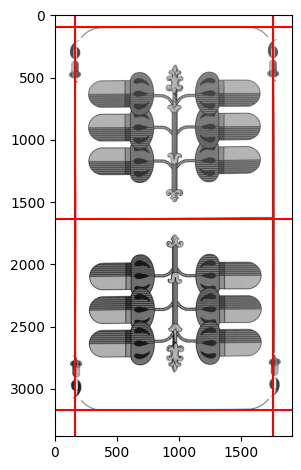

In [7]:
ACCU_FILTER_SIZE = 3
ACCU_NMP_RADIUS = 100

sigma = ACCU_FILTER_SIZE / 5
filter_offs = ACCU_FILTER_SIZE // 2
X = np.arange(-filter_offs, filter_offs + 1)
GAUSS_FILTER = np.exp(-X**2 / (2 * sigma * sigma))


def detect_lines(acc, n):
    # Gaussian smoothing
    acc = scipy.ndimage.convolve(acc, GAUSS_FILTER, mode='constant', cval=0)
    # Detect lines with non-maximum suppression
    lines = []
    while (len(lines) < n) and np.any(acc):
        # Find point with highest scores
        i = np.argmax(acc)
        lines.append(i)
        # Eliminate non-maxima in the local neighborhood
        acc[max(0, i - ACCU_NMP_RADIUS):i + ACCU_NMP_RADIUS] = 0
    return lines

vertical_lines = detect_lines(vertical_accumulator, 2)
horizontal_lines = detect_lines(horizontal_accumulator, 3)

plt.figure()
plt.imshow(image, cmap='gray')
for x in vertical_lines:
    plot_vertical(x, image.shape)
for y in horizontal_lines:
    plot_horizontal(y, image.shape)
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()

## 6. Find Center of the card

The center of the card is the center of its rectangle border. We want that to be the same as the center of the image.

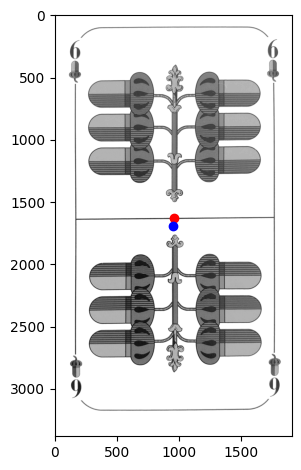

In [8]:
x_center = np.mean([np.min(vertical_lines), np.max(vertical_lines)])
y_center = np.mean([np.min(horizontal_lines), np.max(horizontal_lines)])
x_center_wanted = image.shape[1] // 2
y_center_wanted = image.shape[0] // 2

plt.figure()
plt.imshow(image, cmap='gray')
plt.plot(x_center, y_center, 'ro')
plt.plot(x_center_wanted, y_center_wanted, 'bo')
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()

## 7. Shift Image

-3 60


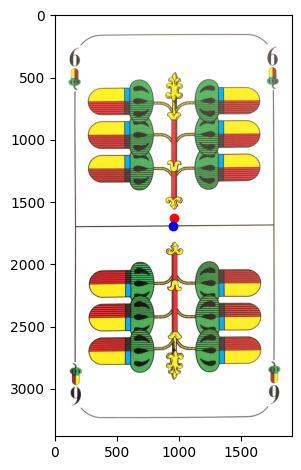

In [9]:
x_offset = round(x_center_wanted - x_center)
y_offset = round(y_center_wanted - y_center)
print(x_offset, y_offset)
pil_image = Image.fromarray(original_image)
pil_image = ImageChops.offset(pil_image, x_offset, y_offset)
image = np.array(pil_image)
plt.figure()
plt.imshow(image, cmap='gray')
plt.plot(x_center, y_center, 'ro')
plt.plot(x_center_wanted, y_center_wanted, 'bo')
plt.ylim(image.shape[0] - 1, 0)
plt.xlim(0, image.shape[1] - 1)
plt.tight_layout()
plt.show()